In [1]:
#First, some imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import h5py
from ednn import EDNN_helper
%matplotlib inline

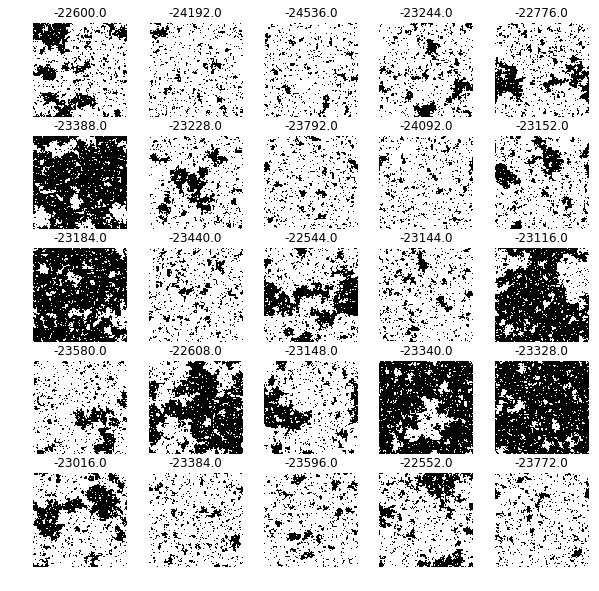

In [2]:
def get_data(N):
    assert N<=8900, "N must be less than 8900"
    
    with h5py.File("./data/ising_128.h5",'r') as F:
        data = F['data'][:N, ...,0]*1.0
        label = F['energy'][:N, ...]*1.0
    return data, label    


data, labels =  get_data(25)
fig, axs = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        axs[i][j].imshow(data[5*i+j,:,:], cmap='gray')
        axs[i][j].set_title('{0}'.format(labels[5*i+j][0]))
        axs[i][j].axis("off")

In [4]:
L = 128
f = 4
c = 1

def NN(_in):
    tile_size = f + 2*c
    _in = tf.reshape(_in, (-1, tile_size**2))
    nn = tf.contrib.layers.fully_connected(_in, 32)
    nn = tf.contrib.layers.fully_connected(nn, 1, activation_fn=None)
    return nn

tf.reset_default_graph()
#data comes in a [ batch * L * L ] tensor, and labels a [ batch * 1] tensor
x = tf.placeholder(tf.float32, (None, L, L), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

helper = EDNN_helper(L=L, f=f, c=c)

#Then the EDNN-specific code:
tiles = tf.map_fn(helper.ednn_split, x, back_prop=False)
tiles = tf.transpose(tiles, perm=[1,0,2,3,4])
output = tf.map_fn(NN, tiles, back_prop=True)
output = tf.transpose(output, perm=[1,0,2])
predicted = tf.reduce_sum(output, axis=1)


#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))

#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

sess = tf.InteractiveSession()
sess.run(init)


In [5]:
saver = tf.train.Saver()
saver.restore(sess, "./checkpoints/ednn_2_Ising/model_trained_more")

INFO:tensorflow:Restoring parameters from ./checkpoints/ednn_2_Ising/model_trained_more


In [6]:
test_data, test_labels = get_data(2000)
prediction = sess.run(pred icted, feed_dict={x: test_data})

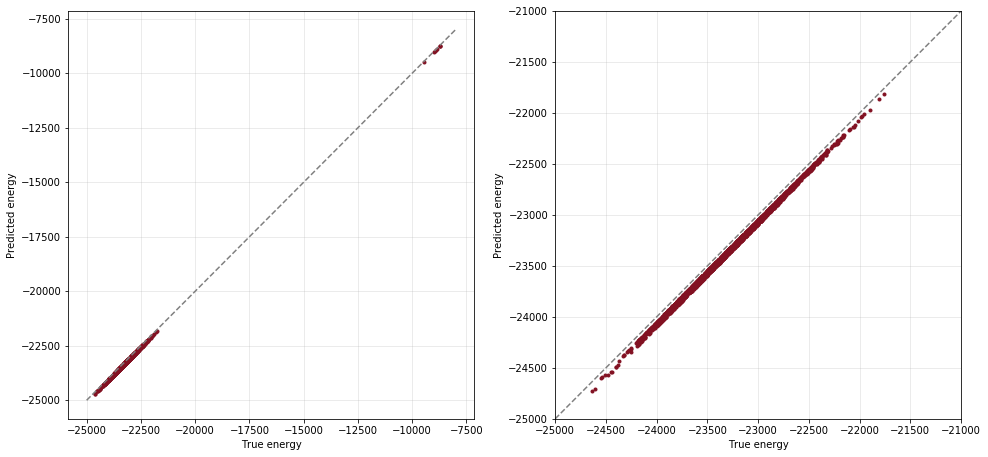

The median absolute error is 55.390625


In [23]:
fig, (ax,ax1) = plt.subplots(1,2, figsize=(16,7.5))
for axx in (ax1, ax):
    axx.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
    axx.plot(np.arange(-25000,-8000), np.arange(-25000,-8000), '--', color='gray')
    axx.set_xlabel("True energy")
    axx.set_ylabel("Predicted energy")
    axx.grid(alpha=0.3)
ax1.set_xlim([-25000,-21000])
ax1.set_ylim([-25000,-21000])
plt.show()
print "The median absolute error is", np.median(np.abs(test_labels-prediction))

## Going bigger

In [14]:
%%writefile test.py

#First, some imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import progressbar
import h5py
from ednn import EDNN_helper
import time


def get_data(N):
    assert N<=10, "N must be less than 8900"
    
    with h5py.File("./data/ising_1024.h5",'r') as F:
        data = F['data'][:N, ...,0]*1.0
        label = F['energy'][:N, ...]*1.0
    return data, label    

if False:
    data, labels =  get_data(9)
    fig, axs = plt.subplots(3,3,figsize=(10,10))
    for i in range(3):
        for j in range(3):
            axs[i][j].imshow(data[3*i+j,:,:], cmap='gray')
            axs[i][j].set_title('{0}'.format(labels[3*i+j][0]))
            axs[i][j].axis("off")


L = 512
f = 4
c = 1

def NN(_in):
    tile_size = f + 2*c
    _in = tf.reshape(_in, (-1, tile_size**2))
    nn = tf.contrib.layers.fully_connected(_in, 32)
    nn = tf.contrib.layers.fully_connected(nn, 1, activation_fn=None)
    return nn

tf.reset_default_graph()
with tf.device('/cpu:0'):
    #data comes in a [ batch * L * L ] tensor, and labels a [ batch * 1] tensor
    x = tf.placeholder(tf.float32, (None, L, L), name='input_image')
y = tf.placeholder(tf.float32, (None, 1))

helper = EDNN_helper(L=L, f=f, c=c)

print "Building graph"
stime = time.time()
#Then the EDNN-specific code:
with tf.device('/cpu:0'):
    tiles = tf.map_fn(helper.ednn_split, x, back_prop=False)
print time.time() - stime
tiles = tf.transpose(tiles, perm=[1,0,2,3,4])
output = tf.map_fn(NN, tiles, back_prop=True)
output = tf.transpose(output, perm=[1,0,2])
predicted = tf.reduce_sum(output, axis=1)


#define the loss function
loss = tf.reduce_mean(tf.square(y-predicted))
#create an optimizer, a training op, and an init op
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession() #config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
saver = tf.train.Saver()
saver.restore(sess, "./checkpoints/ednn_2_Ising/model_trained_more")

test_data, test_labels = get_data(9)
test_data = test_data[0:1, 0:L, 0:L]

print "Beginning inference..."
stime = time.time()
prediction = sess.run(predicted, feed_dict={x: test_data})
print time.time() - stime

if False:
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(16,7.5))
    for axx in (ax1, ax):
        axx.plot(test_labels.flatten(), prediction.flatten(), '.', color='#821122')
        axx.plot(np.arange(-25000,-8000), np.arange(-25000,-8000), '--', color='gray')
        axx.set_xlabel("True energy")
        axx.set_ylabel("Predicted energy")
        axx.grid(alpha=0.3)
    ax1.set_xlim([-25000,-21000])
    ax1.set_ylim([-25000,-21000])
    plt.show()
    print "The median absolute error is", np.median(np.abs(test_labels-prediction))


Overwriting test.py
